In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Unzipping data directly into the drive
!unzip "/content/drive/My Drive/weather_classification/weatherDataset.zip" -d "/content/drive/My Drive/weather_classification"

In [0]:
#Importing all the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
#Keras
import keras
import keras.backend as K 
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from keras.layers import  Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import load_model
#Scikit-Learn
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
#Defining training and validation directories
train_data_dir=r'/content/drive/My Drive/weather_classification/weatherDataset.zip (Unzipped Files)/weatherDataset/train'
val_data_dir=r'/content/drive/My Drive/weather_classification/weatherDataset.zip (Unzipped Files)/weatherDataset/val'

# Defining Data Generators

In [0]:
target_size = (250, 250)
batch_size = 32

#Data Generator for training samples
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=15,
                                   fill_mode='reflect',
                                   data_format='channels_last',
                                   brightness_range=[0.5, 1.5])

#Data Generator for validation samples with no augmentation
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(val_data_dir,
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 1237 images belonging to 4 classes.
Found 295 images belonging to 4 classes.


# BUILDING CNN ARCHITECTURE

In [0]:
class Architecture:
    
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        
        """
        This function builds a sequential CNN model and returns the model

        Parameters:
        width: width of the input image
        height: height of the input image
        depth: Number of channels
        classes: Number of classes to classify
        finalAct: THe activation funtion for the output node
        """
        
        inputShape = (height, width, depth)
        chanDim = -1

        #Checking for data_format
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        #Initializing the he_uniform kernel for weights
        initializer=keras.initializers.he_uniform(seed=200)

        #Sequential Model Building
        model = Sequential()

        #BLOCK 1
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',
                         input_shape = inputShape, kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',kernel_initializer=initializer))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        #BLOCK 2
        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        #BLOCK 3
        model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same',kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same',kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        #BLOCK 4 
        model.add(Conv2D(filters = 256, kernel_size = (5,5),padding = 'same',kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(Conv2D(filters = 256, kernel_size = (5,5),padding = 'same',kernel_initializer=initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        #Classifier
        model.add(GlobalAveragePooling2D())
        model.add(Dense(512, activation = "relu",kernel_initializer=initializer))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation = "relu",kernel_initializer=initializer))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation = finalAct))

        return model

In [0]:
#initialize the number of epochs to train for, initial learning rate, batch size, and image dimensions
epochs = 100
batch_size = 16
img_dims = (250, 250, 3)

In [0]:
#Calling build function to build a sequential model
model = Architecture.build(
    width=img_dims[0], 
    height=img_dims[1],
    depth=img_dims[2], 
    classes=4)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 250, 250, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 250, 250, 32)      128       
_________________________________________________________________
activation_10 (Activation)   (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 250, 250, 32)      9248      
_________________________________________________________________
activation_11 (Activation)   (None, 250, 250, 32)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 250, 250, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 125, 125, 32)     

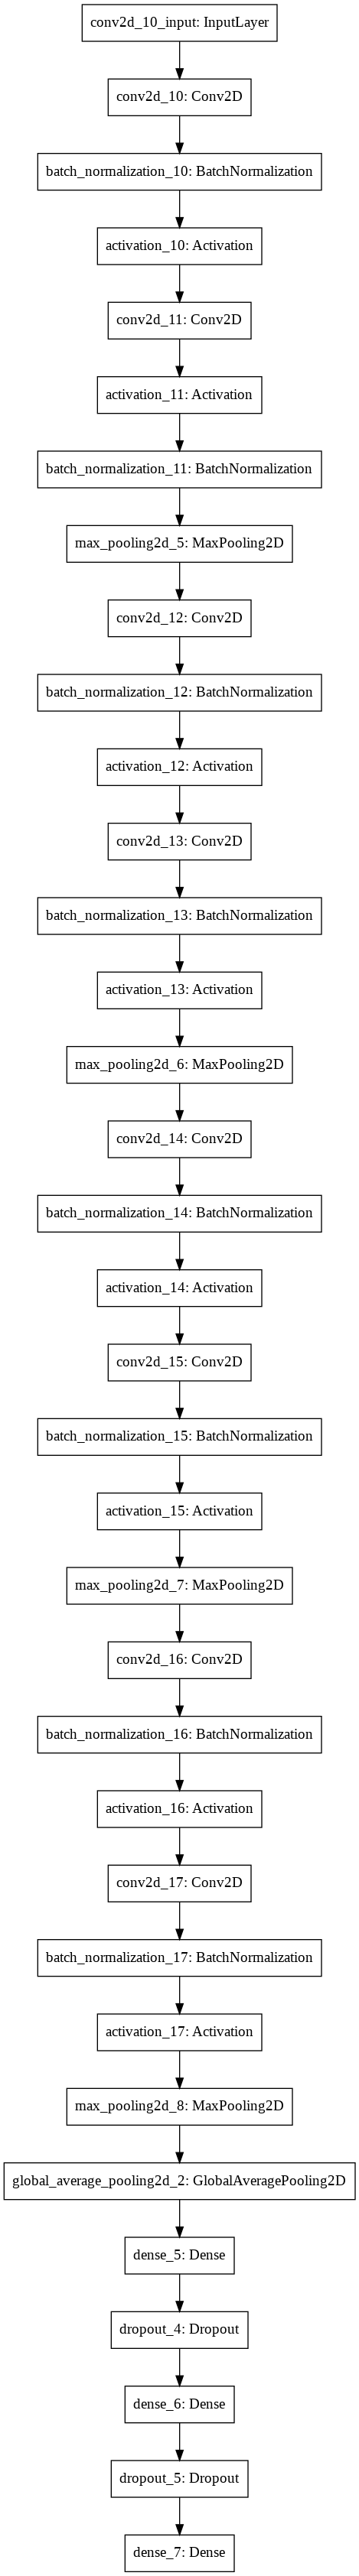

In [0]:
#Saving the model structure to visualize
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
#Using Adam optimizer with an initial learning rate of 0.0001
opt=Adam(lr=0.001, beta_1=0.91, beta_2=0.999, epsilon=1e-08, decay=0.0)
#Compile the model
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

In [0]:
#Defining Callbacks
def myCallbacks():
    """This function returns a list of callbacks"""

    #Model Checkpoint
    # file_path = r"/content/drive/My Drive/weather_classification/MODEL.h5"
    # checkpoint = callbacks.ModelCheckpoint(file_path,monitor='val_acc',verbose=1,save_best_only=True,mode='auto')
    #ReduceLROnPlateau
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_acc',factor=0.1,patience=5,min_lr=1e-30,cooldown=3,verbose=1)
    #EarlyStopping
    #es = callbacks.EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=15)
    return [reduce_lr]

In [0]:
#Training the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n// batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.n// batch_size,
    epochs = epochs,
    verbose=1,
    callbacks=myCallbacks()
    )

Epoch 1/100
77/77 [==============================] - 66s 856ms/step - loss: 0.6546 - acc: 0.7692 - val_loss: 1.3110 - val_acc: 0.7060
Epoch 2/100
77/77 [==============================] - 68s 885ms/step - loss: 0.5601 - acc: 0.8013 - val_loss: 0.7851 - val_acc: 0.7338
Epoch 3/100
77/77 [==============================] - 65s 843ms/step - loss: 0.5132 - acc: 0.8327 - val_loss: 0.8019 - val_acc: 0.7376
Epoch 4/100
77/77 [==============================] - 63s 824ms/step - loss: 0.4509 - acc: 0.8463 - val_loss: 0.3527 - val_acc: 0.8802
Epoch 5/100
77/77 [==============================] - 63s 814ms/step - loss: 0.4152 - acc: 0.8551 - val_loss: 0.4835 - val_acc: 0.8080
Epoch 6/100
77/77 [==============================] - 63s 812ms/step - loss: 0.4426 - acc: 0.8461 - val_loss: 0.2574 - val_acc: 0.9038
Epoch 7/100
77/77 [==============================] - 64s 835ms/step - loss: 0.3598 - acc: 0.8847 - val_loss: 0.7597 - val_acc: 0.8232
Epoch 8/100
77/77 [==============================] - 63s 820ms

# Model Evaluation

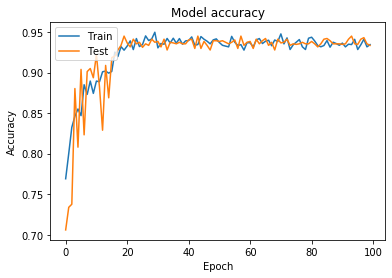

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

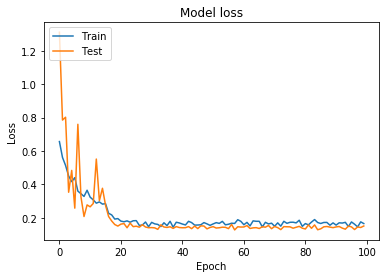

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.evaluate_generator(train_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

[0.11510079176968495, 0.9579628133060668]

So the maximum accuracy i got 95% with the minimum loss of 0.11

In [0]:
#Saving the model
model.save("/content/drive/My Drive/weather_classification/final_model.h5")

# Classification Report

In [0]:
#Defining a test data generator for making predictions on the complete test folder
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = '/content/drive/My Drive/weather_classification/weatherDataset.zip (Unzipped Files)/weatherDataset/val'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 295 images belonging to 4 classes.


In [0]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [0]:
#Making predictions
predict = model.predict_generator(test_generator,steps = nb_samples)

In [0]:
#Getting predicted classes with higher probability using argmax 
predicted_classes = predict.argmax(axis=-1)

In [0]:
#Classification Report
print(classification_report(test_generator.classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        76
           1       0.99      0.97      0.98        73
           2       0.84      0.94      0.89        68
           3       0.99      0.99      0.99        78

    accuracy                           0.94       295
   macro avg       0.94      0.94      0.94       295
weighted avg       0.94      0.94      0.94       295



In [0]:
#Confusion matrix
confusion_matrix(test_generator.classes, predicted_classes)

array([[65,  0, 11,  0],
       [ 2, 71,  0,  0],
       [ 2,  1, 64,  1],
       [ 0,  0,  1, 77]])

# Predictions
## I have downloaded random images from web for making predictions

In [0]:
#Loading the model to make predictions
model = load_model('/content/drive/My Drive/weather_classification/final_model.h5')

In [2]:
def predict(path):
    """This functions returns predictions for a given input image

    Parameters: 
    path: path of the image to predict

    """
    #Creating a dictionary of classes as the predict function gives probablities
    actualClasses = { 0:'Cloudy',1:'Rain',2:'Shine',3:'Sunrise' }

    img = load_img(path, target_size=(250, 250))
    img_array = img_to_array(img)

    #Plotting the image
    plt.imshow(img_array/255)
    plt.show()
    img_array = np.expand_dims(img_array, axis=0)

    #Prediction
    pred = model.predict(img_array)
    classes = np.argmax(pred)
    return 'Predicted Class for the input image : {}'.format(actualClasses[classes])

In [0]:
!wget https://pramanaexperience.com/wp-content/uploads/2019/09/mount-batur-sunrise-trekking.jpg

--2020-01-27 09:31:33--  https://pramanaexperience.com/wp-content/uploads/2019/09/mount-batur-sunrise-trekking.jpg
Resolving pramanaexperience.com (pramanaexperience.com)... 45.13.254.43
Connecting to pramanaexperience.com (pramanaexperience.com)|45.13.254.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201475 (197K) [image/jpeg]
Saving to: ‘mount-batur-sunrise-trekking.jpg.1’

mount-batur-sunrise 100%[===================>] 196.75K   330KB/s    in 0.6s    

2020-01-27 09:31:35 (330 KB/s) - ‘mount-batur-sunrise-trekking.jpg.1’ saved [201475/201475]



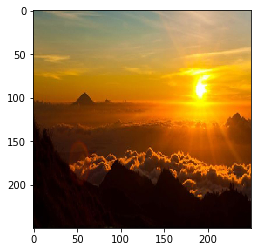

'Predicted Class for the input image : Sunrise'

In [0]:
predict(path="/content/mount-batur-sunrise-trekking.jpg")

In [0]:
!wget https://c.ndtvimg.com/2019-09/psjsc54_heavy-rain-in-mumbai_625x300_04_September_19.jpg

--2020-01-27 09:34:30--  https://c.ndtvimg.com/2019-09/psjsc54_heavy-rain-in-mumbai_625x300_04_September_19.jpg
Resolving c.ndtvimg.com (c.ndtvimg.com)... 23.200.61.77, 2600:1407:1800:48f::24e8, 2600:1407:1800:498::24e8
Connecting to c.ndtvimg.com (c.ndtvimg.com)|23.200.61.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67418 (66K) [image/jpeg]
Saving to: ‘psjsc54_heavy-rain-in-mumbai_625x300_04_September_19.jpg’

psjsc54_heavy-rain- 100%[===================>]  65.84K  --.-KB/s    in 0.01s   

2020-01-27 09:34:31 (6.32 MB/s) - ‘psjsc54_heavy-rain-in-mumbai_625x300_04_September_19.jpg’ saved [67418/67418]



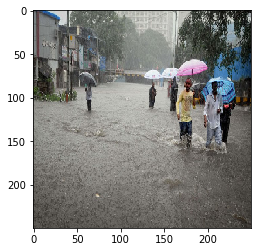

'Predicted Class for the input image : Cloudy'

In [0]:
predict(path="/content/psjsc54_heavy-rain-in-mumbai_625x300_04_September_19.jpg")

In [0]:
!wget https://miro.medium.com/max/10830/0*c7Q-GSzNAEg3V2Fu

--2020-01-27 09:35:29--  https://miro.medium.com/max/10830/0*c7Q-GSzNAEg3V2Fu
Resolving miro.medium.com (miro.medium.com)... 104.16.120.145, 104.16.118.145, 104.16.121.145, ...
Connecting to miro.medium.com (miro.medium.com)|104.16.120.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578446 (1.5M) [image/jpeg]
Saving to: ‘0*c7Q-GSzNAEg3V2Fu’

0*c7Q-GSzNAEg3V2Fu  100%[===================>]   1.50M  --.-KB/s    in 0.06s   

2020-01-27 09:35:29 (27.1 MB/s) - ‘0*c7Q-GSzNAEg3V2Fu’ saved [1578446/1578446]



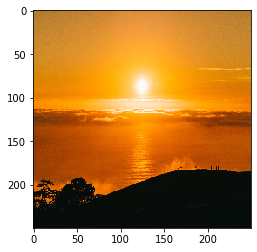

'Predicted Class for the input image : Sunrise'

In [0]:
predict(path="/content/0*c7Q-GSzNAEg3V2Fu")

In [0]:
!wget http://e993.com/forex/imgs/gabans.files.wordpress.com/2012/04/dark-clouds.jpg

--2020-01-27 09:32:11--  http://e993.com/forex/imgs/gabans.files.wordpress.com/2012/04/dark-clouds.jpg
Resolving e993.com (e993.com)... 128.1.242.4
Connecting to e993.com (e993.com)|128.1.242.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://gabans.files.wordpress.com/2012/04/dark-clouds.jpg [following]
--2020-01-27 09:32:13--  http://gabans.files.wordpress.com/2012/04/dark-clouds.jpg
Resolving gabans.files.wordpress.com (gabans.files.wordpress.com)... 192.0.72.16, 192.0.72.17
Connecting to gabans.files.wordpress.com (gabans.files.wordpress.com)|192.0.72.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gabans.files.wordpress.com/2012/04/dark-clouds.jpg [following]
--2020-01-27 09:32:13--  https://gabans.files.wordpress.com/2012/04/dark-clouds.jpg
Connecting to gabans.files.wordpress.com (gabans.files.wordpress.com)|192.0.72.16|:443... connected.
HTTP request sent, awaiting response... 2

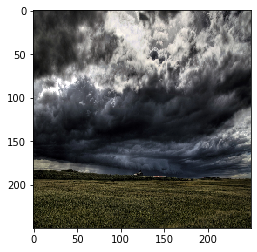

'Predicted Class for the input image : Cloudy'

In [0]:
predict(path="/content/dark-clouds.jpg")

In [0]:
!wget https://images.pond5.com/dark-cloudy-day-brooklyn-neighborhood-footage-082056671_iconl.jpeg

--2020-01-27 09:32:21--  https://images.pond5.com/dark-cloudy-day-brooklyn-neighborhood-footage-082056671_iconl.jpeg
Resolving images.pond5.com (images.pond5.com)... 13.249.134.29, 13.249.134.121, 13.249.134.13, ...
Connecting to images.pond5.com (images.pond5.com)|13.249.134.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33318 (33K) [image/jpeg]
Saving to: ‘dark-cloudy-day-brooklyn-neighborhood-footage-082056671_iconl.jpeg’

dark-cloudy-day-bro 100%[===================>]  32.54K  --.-KB/s    in 0.03s   

2020-01-27 09:32:21 (1.19 MB/s) - ‘dark-cloudy-day-brooklyn-neighborhood-footage-082056671_iconl.jpeg’ saved [33318/33318]



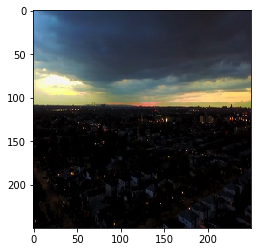

'Predicted Class for the input image : Sunrise'

In [0]:
predict(path="/content/dark-cloudy-day-brooklyn-neighborhood-footage-082056671_iconl.jpeg")

# Conclusion
Trained A CNN classifer from scratch to classify Weather Images with validation accuracy=95.796%